# HILC results for the LiteBIRD + Planck paper

In [8]:
import numpy as np
import healpy as hp
import pickle as pl
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['lines.linewidth'] = 2.0

# Set global font sizes
mpl.rcParams['axes.labelsize'] = 24         # x/y label size
mpl.rcParams['axes.titlesize'] = 18         # subplot title size
mpl.rcParams['xtick.labelsize'] = 18        # tick labels
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['legend.fontsize'] = 13        # legend text
mpl.rcParams['figure.titlesize'] = 20       # optional for fig.suptitle()

from cycler import cycler
import pysm3
import pysm3.units as u
from astropy.io import fits
from astropy.io import ascii

# CHANGE THIS PATH IN ORDER TO MATCH THE PATH OF YOUR PACKAGE
PATH_PACKAGE = '/home/miguel/Desktop/PlanckBIRD-lens'

## Loading the angular power spectra from files

In [9]:
lmax = 2048
T_CMB = 2.7255e6  # in muK
input_dir = 'input'
fileUnlensedCls = 'base_2018_plikHM_TTTEEE_lowl_lowE_lensing_cl.dat'
fileLensedCls = 'base_2018_plikHM_TTTEEE_lowl_lowE_lensing_cl_lensed.dat'
# The column names used in the angular power spectra files are:
# colnames = ['1:l', '2:TT', '3:EE', '4:TE', '5:BB', '6:phiphi', '7:TPhi', '8:Ephi']
unlenCls = ascii.read(f'{PATH_PACKAGE}/{input_dir}/{fileUnlensedCls}', format="commented_header", header_start=10).as_array()
lensCls = ascii.read(f'{PATH_PACKAGE}/{input_dir}/{fileLensedCls}', format="commented_header", header_start=10).as_array()

# We divide by the normalization factor given by CLASS code. We skip l=0 because it leads to an
#  indeterminate form 0/0
factor1 = 2 * np.pi / (unlenCls['1:l'][1:] * (unlenCls['1:l'][1:] + 1))
factor2 = 2 * np.pi / (lensCls['1:l'][1:] * (lensCls['1:l'][1:] + 1))
for name in unlenCls.dtype.names[1:]:
    unlenCls[name][1:] = factor1 * unlenCls[name][1:]
    lensCls[name][1:] = factor2 * lensCls[name][1:]

# Theoretical lensed power spectra.
lensedTheoryCls = np.array([lensCls['2:TT'][:lmax + 1] * T_CMB ** 2,
                                 lensCls['3:EE'][:lmax + 1] * T_CMB ** 2,
                                 lensCls['5:BB'][:lmax + 1] * T_CMB ** 2,
                                 lensCls['4:TE'][:lmax + 1] * T_CMB ** 2])

In [10]:
dire = 'data/mean_spectra_HILC'
experiment = ['LiteBIRD', 'Planck', 'LiteBIRD_Planck']
exp_names = ['\\textit{LiteBIRD}', '\\textit{Planck}', '\\textit{Planck} + \\textit{LiteBIRD}']
fg_cases = ['no_fg', 's1_d1_f1_a1_co1', 's5_d10_a1_f1_co3']
fg_names = ['No fg', 'Simple fg', 'Complex fg']
fg_names_ = ['No-fg', 'Simple-fg', 'Complex-fg']
chance = ['False', 'True', 'True']
mask = ['False', 'True_0.97', 'True_0.97']


def load_power_spectra(exp, fg, nsims, chance):
    mmap = pl.load(open(f"{PATH_PACKAGE}/{dire}/mean_map_{fg}_{exp}_{nsims}_chance_{chance}.pkl", 'rb'))
    mnoise = pl.load(open(f"{PATH_PACKAGE}/{dire}/mean_noise_{fg}_{exp}_{nsims}_chance_{chance}.pkl", 'rb'))
    if fg == 'no_fg':
        return [mmap, mnoise]
    else:
        mresfg = pl.load(open(f"{PATH_PACKAGE}/{dire}/mean_resfg_{fg}_{exp}_{nsims}_chance_{chance}.pkl", 'rb'))
        return [mmap, mnoise, mresfg, mresfg + mnoise]

In [11]:
HILC_dict = {}
for exp in experiment:
    HILC_dict[exp] = {}
    for i, fg in enumerate(fg_cases):
        fname_map = f"{PATH_PACKAGE}/{dire}/mean_map_{exp}_{fg}_chance_{chance[i]}_mask_{mask[i]}_400.pkl"
        fname_noise = f"{PATH_PACKAGE}/{dire}/mean_noise_{exp}_{fg}_chance_{chance[i]}_mask_{mask[i]}_400.pkl"
        fname_fg = f"{PATH_PACKAGE}/{dire}/mean_resfg_{exp}_{fg}_chance_{chance[i]}_mask_{mask[i]}_400.pkl"
        HILC_dict[exp][fg] = {}
        HILC_dict[exp][fg]['map'] = pl.load(open(fname_map, 'rb'))
        HILC_dict[exp][fg]['noise'] = pl.load(open(fname_noise, 'rb'))
        if fg != 'no_fg':
            HILC_dict[exp][fg]['fg'] = pl.load(open(fname_fg, 'rb'))
            HILC_dict[exp][fg]['total res'] = HILC_dict[exp][fg]['fg'] + HILC_dict[exp][fg]['noise']
        else:
            HILC_dict[exp][fg]['total res'] = HILC_dict[exp][fg]['noise']

## Plotting the angular power spectra fixing the experiment and changing the foregrounds

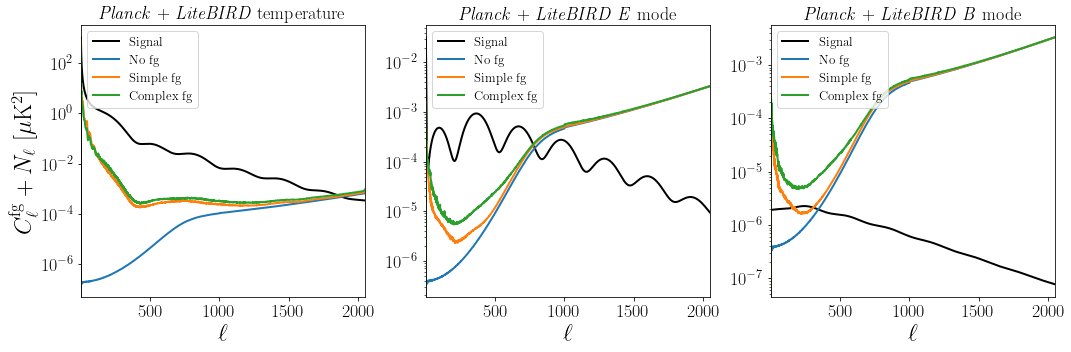

In [12]:
# index = 0
lmax_arr = [1000, 2048, 2048]
res = 'total res'
index = 2
lmax = lmax_arr[index]
L = np.arange(lmax+1)
factor_L = L*(L+1)/(2*np.pi)
exp = experiment[index]
exp_name = exp_names[index]
modes = ['temperature', '\\textit{E} mode', '\\textit{B} mode']

# Create 3x3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

i=0
for mode in range(len(modes)):
    ax = axes[mode]
    ax.plot(lensedTheoryCls[mode], label='Signal', c='k')
    ax.set_title(f"{exp_name} {modes[mode]}")
    for j in range(len(fg_cases)):
        ax.plot(HILC_dict[exp][fg_cases[j]][res][mode], label=f'{fg_names[j]}')
        # ax.plot(HILC_dict[exp][fg_cases[j]]['noise'][mode], linestyle='dashed', label=f'noise {fg_names[j]}')
        ax.legend(loc='upper left')
        ax.set_xlabel(r'$\ell$')
        ax.set_xlim([2, lmax])
        # ax.semilogx()
        ax.semilogy()
        ax.tick_params(axis='both', which='major')
        ax.tick_params(axis='both', which='minor')
    axes[0].set_ylabel(r'$C_\ell^{\rm fg}+N_\ell\ $[$\mu$K$^2$]')

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig(f'{PATH_PACKAGE}/notebooks/plots/Planck_LiteBIRD_residuals.pdf')
plt.show()

## Plotting the angular power spectra fixing the foregrounds and changing the experiment

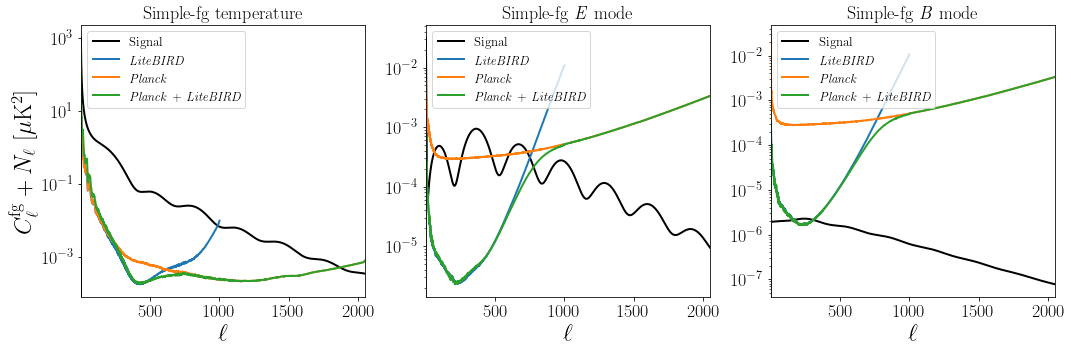

In [13]:
lmax_arr = [1000, 2048, 2048]
res = 'total res'
index = 1
lmax = lmax_arr[index]
L = np.arange(lmax+1)
factor_L = L*(L+1)/(2*np.pi)
exp = experiment[index]
exp_name = exp_names[index]
modes = ['temperature', '\\textit{E} mode', '\\textit{B} mode']

# Create 3x3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

i=0
for mode in range(len(experiment)):
    ax = axes[mode]
    ax.plot(lensedTheoryCls[mode], label='Signal', c='k')
    ax.set_title(f"{fg_names_[index]} {modes[mode]}")
    for j in range(len(experiment)):
        ax.plot(HILC_dict[experiment[j]][fg_cases[index]][res][mode], label=f'{exp_names[j]}')
        ax.legend(loc='upper left')
        ax.set_xlabel(r'$\ell$')
        ax.set_xlim([2, lmax])
        # ax.semilogx()
        ax.semilogy()
        ax.tick_params(axis='both', which='major')
        ax.tick_params(axis='both', which='minor')
    axes[0].set_ylabel(r'$C_\ell^{\rm fg}+N_\ell\ $[$\mu$K$^2$]')

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig(f'{PATH_PACKAGE}/notebooks/plots/s1_d1_residuals.pdf')
plt.show()

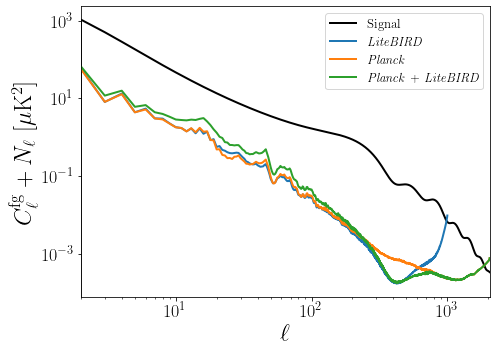

In [14]:
lmax_arr = [1000, 2048, 2048]
res = 'total res'
index = 1
lmax = lmax_arr[index]
L = np.arange(lmax+1)
factor_L = L*(L+1)/(2*np.pi)
exp = experiment[index]
exp_name = exp_names[index]
modes = ['temperature', '\\textit{E} mode', '\\textit{B} mode']

# Create 3x3 subplots
fig, axes = plt.subplots(1, 1, figsize=(7, 5))

i=0
mode = 0
ax = axes
ax.plot(lensedTheoryCls[mode], label='Signal', c='k')
#ax.set_title(f"{fg_names_[index]} {modes[mode]}", fontsize=18)
for j in range(len(experiment)):
    ax.plot(HILC_dict[experiment[j]][fg_cases[index]][res][mode], label=f'{exp_names[j]}')
    ax.legend()
    ax.set_xlabel(r'$\ell$')
    ax.set_xlim([2, lmax])
    ax.semilogx()
    ax.semilogy()
    ax.tick_params(axis='both', which='major')
    ax.tick_params(axis='both', which='minor')
axes.set_ylabel(r'$C_\ell^{\rm fg}+N_\ell\ $[$\mu$K$^2$]')

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig(f'{PATH_PACKAGE}/notebooks/plots/s1_d1_T_residuals_log.pdf')
plt.show()